In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [150]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data_new.csv", index_col="date")

In [151]:
data.head()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.92,8.05,18.63,278.21,475.25,1.3820,139.78,0.5942
19870521,8.87,8.06,18.45,280.17,469.10,1.3864,140.45,0.5956
19870522,8.78,7.97,18.55,282.16,466.50,1.3883,140.60,0.5977
19870526,8.55,7.79,18.63,289.11,449.00,1.4029,143.30,0.6120
19870527,8.60,7.84,18.60,288.73,449.50,1.3988,143.52,0.6200


In [152]:
data.tail()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,3.08,2.81,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,3.12,2.84,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,3.15,2.87,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,3.14,2.84,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,3.22,2.91,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [154]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [155]:
btc_trace = go.Scatter(x=data.index, y=data['spindx'], name= 'spi')
py.iplot([btc_trace])

In [156]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [157]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [158]:
values = data['spindx'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [159]:
values

array([[ 278.21],
       [ 280.17],
       [ 282.16],
       ...,
       [2711.74],
       [2740.37],
       [2723.06]], dtype=float32)

In [160]:
scaled

array([[0.02005667],
       [0.02078077],
       [0.02151594],
       ...,
       [0.9190898 ],
       [0.92966676],
       [0.9232718 ]], dtype=float32)

In [161]:
#split dataset into train and test, 70% train 30% test

In [162]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [163]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1, predict_forward = 1-1): #predict_forward = 0 means predict the next day
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+predict_forward, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [164]:
look_back = 5 #use 3 previous days to predict the next day
predict_foward = 5 #user input
trainX, trainY = create_dataset(train, look_back, predict_foward-1)
testX, testY = create_dataset(test, look_back, predict_foward-1)

5542
2371


In [165]:
trainX

array([[0.02005667, 0.02078077, 0.02151594, 0.02408352, 0.02394314],
       [0.02078077, 0.02151594, 0.02408352, 0.02394314, 0.02469309],
       [0.02151594, 0.02408352, 0.02394314, 0.02469309, 0.02444927],
       ...,
       [0.2524983 , 0.26056677, 0.25318176, 0.25285295, 0.24382764],
       [0.26056677, 0.25318176, 0.25285295, 0.24382764, 0.24720797],
       [0.25318176, 0.25285295, 0.24382764, 0.24720797, 0.24344343]],
      dtype=float32)

In [166]:
trainY

array([0.02569427, 0.02629275, 0.02568688, ..., 0.2510501 , 0.24545687,
       0.2449655 ], dtype=float32)

In [167]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [168]:
trainX

array([[[0.02005667, 0.02078077, 0.02151594, 0.02408352, 0.02394314]],

       [[0.02078077, 0.02151594, 0.02408352, 0.02394314, 0.02469309]],

       [[0.02151594, 0.02408352, 0.02394314, 0.02469309, 0.02444927]],

       ...,

       [[0.2524983 , 0.26056677, 0.25318176, 0.25285295, 0.24382764]],

       [[0.26056677, 0.25318176, 0.25285295, 0.24382764, 0.24720797]],

       [[0.25318176, 0.25285295, 0.24382764, 0.24720797, 0.24344343]]],
      dtype=float32)

In [169]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5542 samples, validate on 2371 samples
Epoch 1/20
5542/5542 [==============================] - 1s 234us/step - loss: 0.0340 - val_loss: 0.0711
Epoch 2/20
5542/5542 [==============================] - 0s 72us/step - loss: 0.0531 - val_loss: 0.0261
Epoch 3/20
5542/5542 [==============================] - 0s 70us/step - loss: 0.0244 - val_loss: 0.0198
Epoch 4/20
5542/5542 [==============================] - 0s 70us/step - loss: 0.0112 - val_loss: 0.0156
Epoch 5/20
5542/5542 [==============================] - 0s 70us/step - loss: 0.0092 - val_loss: 0.0237
Epoch 6/20
5542/5542 [==============================] - 0s 69us/step - loss: 0.0151 - val_loss: 0.0179
Epoch 7/20
5542/5542 [==============================] - 0s 69us/step - loss: 0.0225 - val_loss: 0.0151
Epoch 8/20
5542/5542 [==============================] - 0s 69us/step - loss: 0.0151 - val_loss: 0.0289
Epoch 9/20
5542/5542 [==============================] - 0s 69us/step - loss: 0.0134 - val_loss: 0.0186
Epoch 10/20
5542/5542 [=

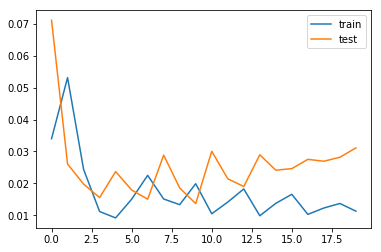

In [170]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

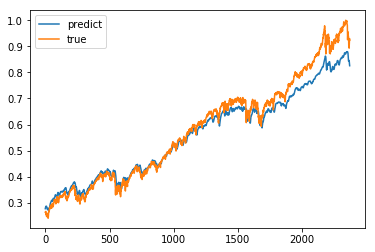

In [171]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [172]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [173]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 115.334


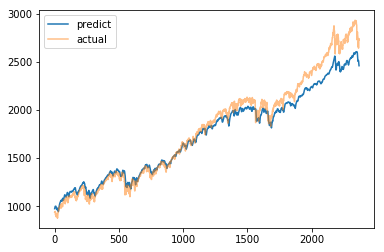

In [174]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [175]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [176]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [177]:
#sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [302]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #print(cols)
#     # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [303]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [304]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [305]:
#normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [306]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [391]:
#convert data to become supervised 
look_back = 5
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed
#t-1 is the current period (closest historic data)
#t is the first predicted period

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
5,278.209991,8.05,8.92,18.629999,475.250000,1.3820,139.779999,0.5942,280.170013,8.06,...,143.520004,0.6200,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152
6,280.170013,8.06,8.87,18.450001,469.100006,1.3864,140.449997,0.5956,282.160004,7.97,...,143.399994,0.6152,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137
7,282.160004,7.97,8.78,18.549999,466.500000,1.3883,140.600006,0.5977,289.109985,7.79,...,144.100006,0.6137,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157
8,289.109985,7.79,8.55,18.629999,449.000000,1.4029,143.300003,0.6120,288.730011,7.84,...,145.449997,0.6157,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085
9,288.730011,7.84,8.60,18.600000,449.500000,1.3988,143.520004,0.6200,290.760010,7.81,...,142.250000,0.6085,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086
10,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152,290.100006,7.69,...,142.800003,0.6086,295.089996,7.76,8.58,18.780001,452.750000,1.4006,144.300003,0.6161
11,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137,289.829987,7.67,...,144.300003,0.6161,293.450012,7.66,8.50,18.650000,453.500000,1.4008,143.800003,0.6131
12,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157,288.459991,7.85,...,143.800003,0.6131,296.720001,7.68,8.53,18.750000,456.549988,1.4006,143.449997,0.6103
13,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085,293.470001,7.78,...,143.449997,0.6103,297.279999,7.71,8.56,18.780001,452.649994,1.3992,142.500000,0.6020
14,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086,295.089996,7.76,...,142.500000,0.6020,297.470001,7.68,8.56,18.780001,455.649994,1.3916,142.449997,0.6030


In [392]:
#look_back = 5
number_of_variables = 8
#keeping first varible in first period
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True) 
#print(reframed.head())

reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)
#print(reframed.head())

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [393]:
reframed.shape

(7926, 41)

In [394]:
#scaled.shape
#print(scaled)
#splitting data 
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [395]:
scaled

array([[0.02005667, 0.80840165, 0.85214452, ..., 0.80541707, 0.41605007,
        0.0246931 ],
       [0.02078077, 0.80942627, 0.84650116, ..., 0.80399143, 0.40239036,
        0.02444927],
       [0.02151595, 0.80020489, 0.83634313, ..., 0.81230709, 0.39812169,
        0.02434951],
       ...,
       [0.89853448, 0.27459015, 0.19525959, ..., 0.44000955, 0.88702325,
        0.91908985],
       [0.91681046, 0.27663933, 0.19977429, ..., 0.44119747, 0.87848608,
        0.92966685],
       [0.89949127, 0.27151639, 0.19300226, ..., 0.44036592, 0.8451906 ,
        0.92327189]])

In [396]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [397]:
#train_X

In [398]:
#train_y

In [399]:
train_X.shape

(5548, 40)

In [400]:
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5548, 1, 40) (5548,) (2378, 1, 40) (2378,)


In [401]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=30, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 5548 samples, validate on 2378 samples
Epoch 1/30
5548/5548 [==============================] - 3s 558us/step - loss: 0.0619 - val_loss: 0.1510
Epoch 2/30
5548/5548 [==============================] - 0s 75us/step - loss: 0.1452 - val_loss: 0.1751
Epoch 3/30
5548/5548 [==============================] - 0s 71us/step - loss: 0.0789 - val_loss: 0.1637
Epoch 4/30
5548/5548 [==============================] - 0s 71us/step - loss: 0.0804 - val_loss: 0.1737
Epoch 5/30
5548/5548 [==============================] - 0s 71us/step - loss: 0.0824 - val_loss: 0.1450
Epoch 6/30
5548/5548 [==============================] - 0s 71us/step - loss: 0.0781 - val_loss: 0.1171
Epoch 7/30
5548/5548 [==============================] - 0s 69us/step - loss: 0.0650 - val_loss: 0.1167
Epoch 8/30
5548/5548 [==============================] - 0s 68us/step - loss: 0.0427 - val_loss: 0.1315
Epoch 9/30
5548/5548 [==============================] - 0s 69us/step - loss: 0.0341 - val_loss: 0.1403
Epoch 10/30
5548/5548 [=

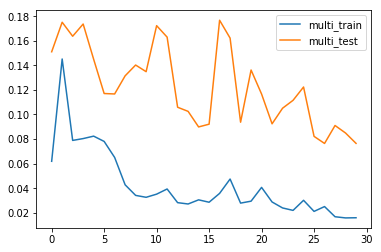

In [402]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [ ]:
#plot prediction
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
test_X.shape

In [ ]:
# invert scaling for prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X[:, :-1]
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat.shape
inv_yhat = inv_yhat[:,-1]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# inv_y
# inv_yhat

#inv_y

In [ ]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
#len(inv_y)

In [ ]:
#print(pd.DataFrame(inv_y))

In [ ]:
#data.tail(len(inv_y)).index

In [ ]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])